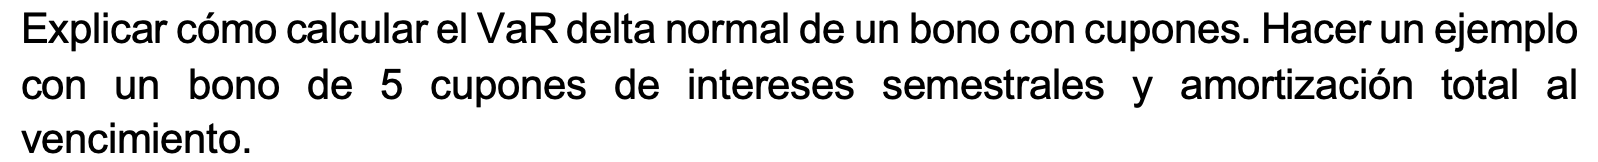

In [1]:
# imports 
import numpy as np
import pandas as pd
import random

from numpy.random import seed
from numpy.random import randint

import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff

from math import log, sqrt, exp
from scipy.stats import norm

In [2]:
# set number of scenarios
number_of_scenarios = 5000

# set alpha
alpha = 0.01

# set model params for basic scenario
betas_standard = [0.05, 0.02, 0.51]
lambd = 0.042

# set parameters
maturities = [0.5, 1, 1.5, 2, 2.5, 3]
cupons = [5, 5, 5, 5, 5, 100]

##### Parameters generation

In [3]:
betas = []
# generating betas for different scenarios 
for x in list(range(number_of_scenarios)):
    scenario = np.empty(shape=len(betas_standard))
    
    for i in list(range(len(betas_standard))):
        # adding noise
        scenario[i] = betas_standard[i] + norm.ppf(random.random(), scale=0.01)
    
    betas.append(scenario)

columns = []
# generating list of columns names
for name in list(range(1,number_of_scenarios+1)):
    columns.append('Esc_{}'.format(str(name)))

# pandas DataFrame with Betas
df_params = pd.DataFrame(np.array(betas).T, columns = columns)
df_params.head()

,Esc_1,Esc_2,Esc_3,Esc_4,Esc_5,Esc_6,Esc_7,Esc_8,Esc_9,Esc_10,...,Esc_4991,Esc_4992,Esc_4993,Esc_4994,Esc_4995,Esc_4996,Esc_4997,Esc_4998,Esc_4999,Esc_5000
0,0.045335,0.044508,0.045169,0.069254,0.034604,0.038084,0.064603,0.055236,0.055884,0.057640,...,0.052339,0.052298,0.034749,0.055193,0.053283,0.061014,0.043587,0.038235,0.068572,0.040818
1,0.011546,0.012975,-0.000454,0.035300,0.023088,0.035754,0.012280,0.016652,0.011095,0.029484,...,-0.000942,0.013574,0.012793,0.034010,0.037262,0.041828,0.010592,0.019890,0.019124,0.020352
2,0.516228,0.500663,0.512015,0.497886,0.522615,0.507109,0.514902,0.500718,0.522360,0.502690,...,0.512659,0.528325,0.495417,0.517943,0.490367,0.505544,0.497572,0.510355,0.505246,0.509208


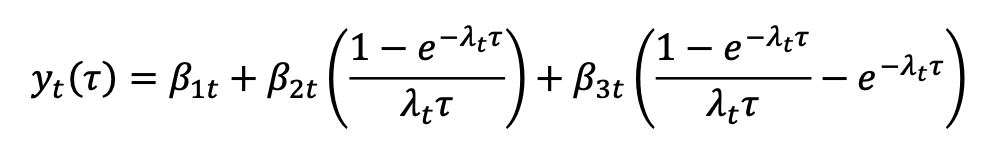
##### Calculating yields by using Nelson-Siegel model

In [4]:
yields_standard = []

for i in list(range(len(maturities))):
    # Dividing Nelson-Siegel formula into separate variables
    parte_1 = betas_standard[0]
    parte_2 = betas_standard[1] * (1 - exp(-lambd * maturities[i]) ) / (lambd * maturities[i])
    parte_3 = betas_standard[2] * ( (1 - exp(-lambd * maturities[i]) ) / (lambd * maturities[i]) - exp(-lambd * maturities[i]) )
    
    # combing into N-S formula
    y = parte_1 + parte_2 + parte_3 
    
    yields_standard.append(y)

list_of_arrays = []

for beta in betas:
    scenario = np.empty(shape=len(maturities))
    
    for i in list(range(len(maturities))):
        
        parte_1 = beta[0]
        parte_2 = beta[1] * (1 - exp(-lambd * maturities[i]) ) / (lambd * maturities[i])
        parte_3 = beta[2] * ( (1 - exp(-lambd * maturities[i]) ) / (lambd * maturities[i]) - exp(-lambd * maturities[i]) )
        
        y = parte_1 + parte_2 + parte_3 
        scenario[i] = y
    list_of_arrays.append(scenario)

# pandas DataFrame with yield's values
df_yields = pd.DataFrame(np.array(list_of_arrays).T, columns = columns, index=maturities)
df_yields.head(3)

,Esc_1,Esc_2,Esc_3,Esc_4,Esc_5,Esc_6,Esc_7,Esc_8,Esc_9,Esc_10,...,Esc_4991,Esc_4992,Esc_4993,Esc_4994,Esc_4995,Esc_4996,Esc_4997,Esc_4998,Esc_4999,Esc_5000
0.5,0.062106,0.062532,0.050021,0.109341,0.062863,0.078716,0.082087,0.076899,0.072271,0.092022,...,0.056715,0.071200,0.052538,0.094211,0.095234,0.107641,0.059220,0.063202,0.092728,0.066231
1.0,0.067184,0.067438,0.055180,0.113990,0.067886,0.083453,0.087144,0.081769,0.077416,0.096779,...,0.061886,0.076379,0.057394,0.099076,0.099787,0.112300,0.064121,0.068135,0.097618,0.071147
1.5,0.072119,0.072207,0.060195,0.118505,0.072767,0.088054,0.092059,0.086500,0.082416,0.101400,...,0.066913,0.081412,0.062113,0.103800,0.104209,0.116824,0.068883,0.072928,0.102369,0.075925


##### Calculating portfolio value and VaR

In [5]:
base_scen_bond_value = 0

for i in list(range(len(maturities))):
    cupon = cupons[i] * exp(-1 * yields_standard[i] * maturities[i])
    base_scen_bond_value += cupon

# list of bond(portfolio values)
bond_values = []

for scenario in list_of_arrays:
    bond_cf = []
    
    for i in list(range(len(maturities))):
        cupon = cupons[i] * exp(-1 * scenario[i] * maturities[i])
        bond_cf.append(cupon)
    
    bond_values.append(np.sum(bond_cf))
    
VaR_value = np.round(np.percentile(bond_values, alpha),2)
print('Alpha: {}'.format(alpha))
print('Basic scenario value: {}'.format(np.round(base_scen_bond_value,2)))
print('VaR Value: {}'.format(VaR_value))
print('VaR P&L: {}'.format(np.round(base_scen_bond_value - VaR_value,2)))

Alpha: 0.01
Basic scenario value: 96.42
VaR Value: 84.15
VaR P&L: 12.27
